***

<font color='green'>

# Project Solution: Statistical NLP (Part 1)

#### Domain: Digital content management

#### Context: Classification is probably the most popular task that you would deal with in real life. Text in the form of blogs, posts, articles, etc. is written every second. It is a challenge to predict the information about the writer without knowing about him/her. We are going to create a classifier that predicts multiple features of the author of a given text. We have designed it as a Multi label classification problem.

#### Objective: Build a NLP classifier which can use input text parameters to determine the label(s) of of the blog.

#### Dataset comprises of the Blog Authorship corpus consisting of the collected posts of 19,320 bloggers gathered from blogger.com in August 2004. The corpus incorporates a total of 681,284 posts and over 140 million words - or approximately 35 posts and 7250 words per person.

#### All bloggers included in the corpus fall into one of three age groups:
- 8240 "10s" blogs (ages 13-17),
- 8086 "20s" blogs(ages 23-27) and
- 2994 "30s" blogs (ages 33-47)

#### For each age group, there is an equal number of male and female bloggers.
#### Each blog in the corpus includes at least 200 occurrences of common English words. All formatting has been stripped with two exceptions. Individual posts within a single blogger are separated by the date of the following post and links within a post are denoted by the label url link.
#### Source: https://www.kaggle.com/rtatman/blog-authorship-corpus

#### Learning Outcome: Text data pre-processing (cleansing, vectorization etc.), train, tune and test the best classifier.
***
***
*Prepared by: Sauvik De*

*Date: September 12, 2021*
    
</font>

***

In [1]:
# Import necessary libraries and functions/methods
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import re
import nltk
import spacy
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import hamming_loss, average_precision_score, f1_score, jaccard_score, classification_report

#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

In [2]:
# Additional Settings:
# =====================
# suppress display of warnings
import warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

#### Read in blog text datafile

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/AI-ML/NLP_Project/Blog_Authorship_Analysis'
blogs = pd.read_csv('Dataset - blogtext.csv')

Mounted at /content/drive
/content/drive/MyDrive/AI-ML/NLP_Project/Blog_Authorship_Analysis


In [4]:
print('Size of the dataframe:', blogs.shape)

Size of the dataframe: (681284, 7)


In [5]:
print('Check 10 random samples of blogs dataset:')
blogs.sample(n=10)

Check 10 random samples of blogs dataset:


,id,gender,age,topic,sign,date,text
159106,3841794,male,17,indUnk,Gemini,"05,August,2004",Tonight I was treated to dinner that wa...
317349,2966778,male,13,Student,Taurus,"23,May,2004",The urlLink McDonald's Go Active...
181901,3616080,female,17,Engineering,Aquarius,"12,June,2004",It's my first time using th...
153076,4217949,female,16,indUnk,Cancer,"13,August,2004",hey everyone im current...
154210,1770781,female,24,Agriculture,Taurus,"23,February,2004",Last week I was complimenting the...
24515,546850,male,24,indUnk,Aries,"27,September,2002",- Image taken from www.thespark.com...
190056,1862467,female,27,indUnk,Cancer,"23,January,2004",Renee over at urlLink Like a Baby alo...
144417,3422672,male,25,indUnk,Cancer,"25,May,2004",Theres been some work done to the websi...
412003,1826362,male,27,Student,Aquarius,"07,May,2004",Because I know that people only read th...
322751,2420099,male,25,Telecommunications,Pisces,"17,March,2004",Well I get off of work to find ou...


In [6]:
blogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


In [7]:
blogs.isna().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

- Dataset consists of 6,81,284 blogs and for each blogger ID we are provided with gender, age, topic, sign, date and blog text.
- Blogger ID and Age are numerical, while the rest of columns are non-numerical (date, cagtegorical - binary, nominal etc.).
- There seems to be no missing data.

In [8]:
print('Dataset consists of a total of', blogs['id'].nunique(), 'bloggers.')

Dataset consists of a total of 19320 bloggers.


In [9]:
blogs[['gender', 'id']].drop_duplicates()['gender'].value_counts()

male      9660
female    9660
Name: gender, dtype: int64

In [10]:
print('Gender frequency distribution considering blogs written:')
blogs['gender'].value_counts()

Gender frequency distribution considering blogs written:


male      345193
female    336091
Name: gender, dtype: int64

- While there are equal no. of males and females in the dataset, there are marginally higher number (9104, 2.7% higher) of blogs written by males vs females.

In [11]:
blogs['age'].describe()

count   681284.0000000
mean        23.9323263
std          7.7860087
min         13.0000000
25%         17.0000000
50%         24.0000000
75%         26.0000000
max         48.0000000
Name: age, dtype: float64

In [12]:
print('Age of bloggers available in the dataset:')
np.array(pd.Series(blogs['age'].unique()).sort_values())

Age of bloggers available in the dataset:


array([13, 14, 15, 16, 17, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48])

In [13]:
temp = blogs[['age', 'gender', 'id']].drop_duplicates()

agegrp1 = temp[((temp['age'] >= 13) & (temp['age'] <= 17))]
agegrp2 = temp[((temp['age'] >= 23) & (temp['age'] <= 27))]
agegrp3 = temp[((temp['age'] >= 33) & (temp['age'] <= 48))]

print('No. of bloggers with age between 13 and 17:', agegrp1.shape[0])
print('No. of bloggers with age between 23 and 27:', agegrp2.shape[0])
print('No. of bloggers with age between 33 and 48:', agegrp3.shape[0])

print('\nGender distribution [Age-group 13-17]:')
print(agegrp1['gender'].value_counts())

print('\nGender distribution [Age-group 23-27]:')
print(agegrp2['gender'].value_counts())

print('\nGender distribution [Age-group 33-48]:')
print(agegrp3['gender'].value_counts())

No. of bloggers with age between 13 and 17: 8240
No. of bloggers with age between 23 and 27: 8086
No. of bloggers with age between 33 and 48: 2994

Gender distribution [Age-group 13-17]:
female    4120
male      4120
Name: gender, dtype: int64

Gender distribution [Age-group 23-27]:
female    4043
male      4043
Name: gender, dtype: int64

Gender distribution [Age-group 33-48]:
female    1497
male      1497
Name: gender, dtype: int64


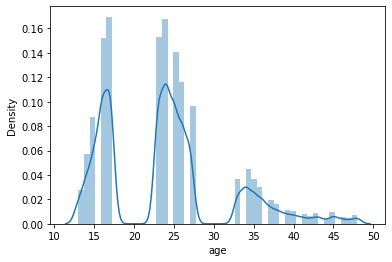

In [14]:
_ = sns.distplot(blogs['age'])

- It is clearly evident that there are three age groups in the dataset - one centering around age 15 (age group 13-17), another centering around age 25 (age group 23-27) and the other centering around age 40 (age group 33-48)
- Out of a total of 19320 bloggers, there are 8240 people in the youngest age-group, 8086 in adult age-group, and 2994 in the elderly age-group with an equal proportion of males and females within each age-group.
- We will convert age column from numeric to categorical using three logical groups

In [15]:
print('There are', blogs['topic'].nunique(), 'topics available in the dataset.')
print('\nFollowings are the topics:')
print(blogs['topic'].unique())

There are 40 topics available in the dataset.

Followings are the topics:
['Student' 'InvestmentBanking' 'indUnk' 'Non-Profit' 'Banking' 'Education'
 'Engineering' 'Science' 'Communications-Media' 'BusinessServices'
 'Sports-Recreation' 'Arts' 'Internet' 'Museums-Libraries' 'Accounting'
 'Technology' 'Law' 'Consulting' 'Automotive' 'Religion' 'Fashion'
 'Publishing' 'Marketing' 'LawEnforcement-Security' 'HumanResources'
 'Telecommunications' 'Military' 'Government' 'Transportation'
 'Architecture' 'Advertising' 'Agriculture' 'Biotech' 'RealEstate'
 'Manufacturing' 'Construction' 'Chemicals' 'Maritime' 'Tourism'
 'Environment']


In [16]:
print('Top 10 frequently occurring topics:')
print(blogs['topic'].value_counts(normalize=True).head(10))

Top 10 frequently occurring topics:
indUnk                 0.3684440
Student                0.2259014
Technology             0.0617290
Arts                   0.0476292
Education              0.0434958
Communications-Media   0.0295618
Internet               0.0234939
Non-Profit             0.0215769
Engineering            0.0171045
Law                    0.0132691
Name: topic, dtype: float64


In [17]:
print('Top 10 frequently occurring topics within male cohort:')
blogs.loc[blogs['gender']=='male', 'topic'].value_counts(normalize=True).head(10)

Top 10 frequently occurring topics within male cohort:


indUnk                 0.3040502
Student                0.2228174
Technology             0.1035131
Education              0.0408351
Arts                   0.0391144
Communications-Media   0.0377789
Internet               0.0343489
Engineering            0.0222281
Non-Profit             0.0210607
Law                    0.0145020
Name: topic, dtype: float64

In [18]:
print('Top 10 frequently occurring topics within female cohort:')
blogs.loc[blogs['gender']=='female', 'topic'].value_counts(normalize=True).head(10)

Top 10 frequently occurring topics within female cohort:


indUnk                 0.4345817
Student                0.2290689
Arts                   0.0563746
Education              0.0462286
Non-Profit             0.0221071
Communications-Media   0.0211223
Technology             0.0188134
Internet               0.0123449
Law                    0.0120027
Engineering            0.0118420
Name: topic, dtype: float64

- Majority of the topics seem to be indUnk (i.e., Industry Unknown) in the population. We will use this as a one 'valid' category for our analysis.
- Out of the remaining 39 topics, Student, Technology, Arts and Education being the most common topics.
- Student is the most common topic within both the male and female cohorts
- Technology is the next most common topic among male bloggers; while Arts is the next most common topic among female bloggers

In [19]:
print('Bloggers have', blogs['sign'].nunique(),'signs available in the data')

temp = blogs[['sign', 'id']].drop_duplicates()
print('\nFrequency distribution of signs across bloggers:')
signFreq = temp['sign'].value_counts()
print(signFreq)

Bloggers have 12 signs available in the data

Frequency distribution of signs across bloggers:
Virgo          1783
Cancer         1722
Libra          1700
Taurus         1645
Scorpio        1631
Leo            1619
Aries          1597
Gemini         1595
Pisces         1580
Sagittarius    1549
Aquarius       1474
Capricorn      1425
Name: sign, dtype: int64


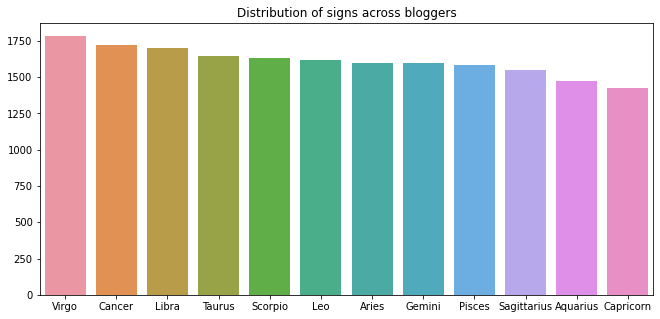

In [20]:
plt.figure(figsize=(11,5))
_ = sns.barplot(x=signFreq.index, y=signFreq.values)
_ = plt.title('Distribution of signs across bloggers')

- Signs are well spread / balanced across bloggers with virgo, cancer and libra being the 3 most common signs while capricorn, aquarius and sagittarius being the 3 least common signs

In [21]:
print('Months for blogs written:')
blogs['date'].apply(lambda x: x.split(',')[1]).unique()

Months for blogs written:


array(['May', 'June', 'July', 'August', 'September', 'October',
       'November', 'December', 'January', 'February', 'March', 'April',
       'julio', 'Mai', 'mars', 'mai', 'juin', 'juillet', 'Julho',
       'Agosto', 'Junho', 'junio', 'agosto', 'Juli', 'abril', 'mayo',
       'septiembre', 'Januar', 'Februar', 'Juni', 'mei', 'juli',
       'febrero', 'marzo', 'octubre', 'giugno', 'luglio', 'janvier',
       'avril', 'septembre', 'octobre', 'novembre', 'augusti', 'juni',
       'Aprill', 'augustus', 'Dezember', 'maj', '', 'Maio', 'septembrie',
       'noiembrie', 'ianuarie', 'februarie', 'iulie', 'august', 'Avgust',
       'september', 'ottobre', 'Jaanuar', 'Juuni', 'Juuli', 'Setembro',
       'Novembro', 'czerwiec', 'lipiec', 'kolovoz', 'lipanj', 'noviembre',
       'diciembre', 'enero', 'Outubro', 'Dezembro', 'Janeiro',
       'Fevereiro', 'Abril', 'desember', 'toukokuu', 'elokuu', 'maart'],
      dtype=object)

In [22]:
print('Blogs written spread across years:')
print(np.array(pd.Series(blogs['date'].apply(lambda x: x.split(',')[2]).unique()).sort_values()))

Blogs written spread across years:
['' '1999' '2000' '2001' '2002' '2003' '2004' '2005' '2006']


- There are months that are non-English. The blogs written are spread from 1999 through 2006.
- However, we may ignore this column for our analysis as evaluating the blog category have little to no effect of dates.
- Also dates are provided to distinguish multiple blogs from the same blogger ordered by time

### Motivation and Strategy:
- Our goal in this study is to predict multiple features of the author given his/her blog text as input in the paradigm of multi-label classification problem
- Author's ID and blogging date may not play any role for this analysis - so we plan to drop these columns
- The rest of the columns - Gender, Age, Sign and Topic - may represent useful info about author's feature based on blog text represented in column 'text'
- We will use column 'text' as input feature and a combined column using (Gender, Age, Sign and Topic) as response
- We will pre-process both the input feature and response
- For the input text, we will perform data cleansing by removing unwanted characters, spaces, stop words etc., converting text to lowercase, and finally vectorize to convert texts into numerics
- For the response, we will concatecate target columns and binarize in multi-label set up before fitting models
- Since age is a numerical column, we can convert it to categorical column by dividing age into three categories as noted during our EDA step. We will also try our analysis keeping age as numerical column as well, if time permits.
- Moreover, we will consider train-validation split prior to applying vectorizer or multi-label binarizer to prevent data leakage

#### Data cleaning and  pre-processing

In [23]:
# Drop columns not required for our analysis
df = blogs.drop(columns = ['id','date'], axis=1, inplace=False)

In [24]:
#df = df[:2000] #testing...

Blog text data clean-up: Remove stopwords and Remove unwanted characters/spaces, HTTP(S) tags using Regular Expressions

In [25]:
# Remove http links from blog texts
regex = re.compile(r'https?://\S+')
df['text'] = [regex.sub(' ', x).strip().lower() for x in df['text'].values.tolist()]

In [26]:
# Clean up text column
# Remove unwanted characters and spaces, and convert to lowercase
#df['text'] = df['text'].apply(lambda x: re.sub('[^\w\s+]', '', x).strip().lower()) ## <- slow
#regex = re.compile('[^\w\s]+')

regex = re.compile('[^A-Za-z\s]')
df['text'] = [regex.sub(' ', x).strip().lower() for x in df['text'].values.tolist()]

In [27]:
# Replace more than one space with just one space
regex = re.compile('\s\s+')
df['text'] = [regex.sub(' ', x).strip().lower() for x in df['text'].values.tolist()]

In [28]:
# Remove stopwords from text column
# cache stopwords list
nltk.download('stopwords')
stopWords = nltk.corpus.stopwords.words('english')
# use Counter, i.e., dictionary (hashmap) to run faster (based off C)
stopwords_dict = Counter(stopWords)
# remove stopwords
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_dict]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
# Lemmatize text column for word normalization using spacy en model

#pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl
#pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
    
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Parse the sentence using the loaded 'en' model object `nlp`

#df['text'] = df['text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

#def lemmatizer(text):        
#    sent = []
#    doc = nlp(text)
#    for word in doc:
#        sent.append(word.lemma_)
#    return ' '.join(sent)

#df['text'] = df['text'].apply(lambda x: lemmatizer(x))

In [30]:
# Lemmatize text column for word normalization using nltk wordnet

nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()

#-------------------------------------------------------------------------------
#tag_dict = {"J": 'a', #nltk.corpus.wordnet.ADJ,
#            "N": 'n', #nltk.corpus.wordnet.NOUN,
#            "V": 'v', #nltk.corpus.wordnet.VERB,
#            "R": 'r' #nltk.corpus.wordnet.ADV
#           }

#def get_wordnet_pos(word):
#    pTag = nltk.pos_tag([word])[0][1][0].upper()
#    return tag_dict.get(pTag, 'n') 

#df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos=get_wordnet_pos(word))
#                                                  for word in x.split()]))   ## <- Customised lemmatization approach takes long long time ......
#-------------------------------------------------------------------------------

# Lemmatize for verbs
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos='v') for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [31]:
# since age can be thought of as ordinal variable in categorical sense, we can ...
# convert ordinal variable into binary one with number of binary variables 
# equalling the number of ordinal categories less 1

# As a reminder, we have three age groups [13-17], [23-27], [33-48] 

# P[age<=17] = 1 - P[age>17] = P(Youngest class)
# P[age>17] - P[age>27]      = P(Adult class)
# P[age>27]                  = P(Elderly class)

# From the above, we have two events to evaluate three age groups:
# [age > 17] and [age > 27]

# https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c
# https://stackoverflow.com/questions/38375401/neural-network-ordinal-classification-for-age

# If we simply use one-hot-encoding, we will loose the ordering information across age groups
# The idea is we don't want to loose the ordinal information within the age variable across three groups

# We can use this for neural neural input to make input more meaningful
df['age_gt_17'] = (df['age']>17).astype(int)
df['age_gt_27'] = (df['age']>27).astype(int)

# Prepare age groups for binary relevance with OvR - with base Logistic Regression/Naive Bayes/Linear SVC etc.
df['ageGrp'] = pd.cut(df['age'], bins=[0,17,27,48], labels=['0_youngest','1_adult','2_elderly'])

In [32]:
# Create a male flag for gender variable (binary)
df['gender_male'] = (df['gender']=='male').astype(int)

In [33]:
# Renaming the categories to maintain grouping for topic and sign (we will one-hot-encode these using Multilabel Binarizer)
df['topic'] = 'topic_' + df['topic']
df['sign']  = 'sign_'  + df['sign']

In [34]:
# Combine target labels (multi-label) into a single column
df['label'] = df[['ageGrp', 'gender', 'topic', 'sign']].values.tolist()

In [35]:
# examine data layout
df[['text', 'label']].sample(5)

,text,label
155540,urllink work iron lace vw bug,"[1_adult, male, topic_indUnk, sign_Sagittarius]"
398373,also censor literature conversations nbsp perh...,"[1_adult, female, topic_indUnk, sign_Capricorn]"
650129,holidaze yikes week christmas kid school janua...,"[2_elderly, female, topic_Technology, sign_Virgo]"
62539,nbsp sometimes feel body dead lifeless carven ...,"[2_elderly, female, topic_indUnk, sign_Cancer]"
281526,love pun really funny ones old yell man home c...,"[0_youngest, male, topic_Non-Profit, sign_Gemini]"


#### Train-Validation split 

In [ ]:
# Training (80%) and validation (20%) split
X_train, X_val, y_train, y_val = train_test_split(df[['text']], df[['label']], test_size=0.2, random_state=1)

In [ ]:
print('X_train shape:', X_train.shape)
print('X_test shape: ', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_test shape: ', y_val.shape)

X_train shape: (545027, 1)
X_test shape:  (136257, 1)
y_train shape: (545027, 1)
y_test shape:  (136257, 1)


#### Encode texts to numerics

In [ ]:
# Vectorize texts - Bag of Words approach
tiVect = TfidfVectorizer(ngram_range=(1,2), min_df=20, max_df=0.95, max_features=None, stop_words='english')
# Compute word vector based on TF-IDF using training dataset
X_train_vect = tiVect.fit_transform(X_train)
# Compute word vector based on TF-IDF using validation dataset
X_val_vect   = tiVect.transform(X_val)

In [ ]:
print('Vocabulary count based on training text set:', len(tiVect.vocabulary_))

Vocabulary count based on training text set: 292272


In [ ]:
# Transform (multi-label) target column
# We will use this at a later point while evaluating model accuracy
mlb = MultiLabelBinarizer()

# Compute binarized flags for multi-labels available in training dataset
y_train_encoded = mlb.fit_transform(y_train['label'])

# Compute binarized flags for multi-labels available in test dataset
y_val_encoded = mlb.transform(y_val['label'])

#### Classification
- Since we are to predict multiple labels and each of the labels does have multiple classes, we can use One vs Rest (OVR) classifier as meta-estimator with Logistic regression as base classifier to train on every label. Alternatively, we may look at Support Vector Machine, Naive Bayes, Random Forest etc.
- Useful links:
    - https://scikit-learn.org/stable/modules/multiclass.html
    - https://scikit-learn.org/stable/modules/preprocessing_targets.html#preprocessing-targets
    - https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier
    - http://palm.seu.edu.cn/zhangml/files/FCS'17.pdf
- Please note that our case falls under 'multiclass-multioutput' as we have multiple targets/labels and each target/label consists of more than 2 categories (ternary, quarternary etc.). At present, no metric in sklearn.metrics supports the multiclass-multioutput classification task.
- We will also try deep neural network to predict the multi-labels using Sigmoid activation function with binary crossentropy as loss function, since the goal is to treat each output label as an independent Bernoulli distribution and we want to penalize each output node independently.


In [ ]:
# base estimtators
lgr = LogisticRegression(solver='lbfgs', multi_class='ovr')
mnb = MultinomialNB()
svc = LinearSVC(multi_class='ovr')

# wrap with meta-estimator OVR
lgr = OneVsRestClassifier(lgr)
mnb = OneVsRestClassifier(mnb)
svc = OneVsRestClassifier(svc)

#NOTE: randomForest took ages to run to fit classifier on this big data

In [ ]:
# Prediction function to fit and predict for multilabel classification
def fit_prediction(clf, X_train, y_train, X_val):

    # Fit base classification model using one-vs-rest classifier
    clf.fit(X_train, y_train)

    print('Model fitted. Moving on to prediction ...')
    
    # Get prediction for training and validation sets
    y_pred_ovr_trn = clf.predict(X_train)
    y_pred_ovr_val = clf.predict(X_val)

    print('Prediction returned.')
    
    return (y_pred_ovr_trn, y_pred_ovr_val)

In [ ]:
# Function to compute evaluation metrics for multilabel classification
def get_evaluation(y_true_train, y_pred_train, y_true_val, y_pred_val):
    
    print('\nCalculating evaluation metrics ...')

    print('Hamming loss on training sample:', hamming_loss(y_true_train, y_pred_train))
    print('Hamming loss on validation sample:', hamming_loss(y_true_val, y_pred_val))

    print('\nJaccard similarity score on training sample:', jaccard_score(y_true_train, y_pred_train, average='micro'))
    print('Jaccard similarity score on validation sample:', jaccard_score(y_true_val, y_pred_val, average='micro'))

    print('\nAverage precision score on training sample:',
          average_precision_score(y_true_train, y_pred_train, average='micro'))
    print('Average precision score on validation sample:',
          average_precision_score(y_true_val, y_pred_val, average='micro'))

    print('\nF1 score on training sample:',
          f1_score(y_true_train, y_pred_train, average='micro'))
    print('F1 score on validation sample:',
          f1_score(y_true_val, y_pred_val, average='micro'))

Logistic Regression - Fit, Evaluate and Predict

In [ ]:
# Base estimator: Logistic regression
# Fit model and get predictions
y_trn_lgr_pred, y_val_lgr_pred = fit_prediction(lgr, X_train_vect, y_train_encoded, X_val_vect)

# Get evaluation score
get_evaluation(y_train_encoded, y_trn_lgr_pred, y_val_encoded, y_val_lgr_pred)

Model fitted. Moving on to prediction ...
Prediction returned.

Calculating evaluation metrics ...
Hamming loss on training sample: 0.04793092658309959
Hamming loss on validation sample: 0.05391334151961805

Jaccard similarity score on training sample: 0.38454543801262114
Jaccard similarity score on validation sample: 0.3306285178986206

Average precision score on training sample: 0.3796715372241396
Average precision score on validation sample: 0.31668163033370333

F1 score on training sample: 0.5554825828823623
F1 score on validation sample: 0.4969508971906927


In [ ]:
# Classification Report
print(classification_report(y_val_encoded, y_val_lgr_pred, target_names=mlb.classes_))

                               precision    recall  f1-score   support

                   0_youngest       0.84      0.68      0.75     47212
                      1_adult       0.69      0.70      0.70     64380
                    2_elderly       0.72      0.27      0.39     24665
                       female       0.72      0.70      0.71     66950
                         male       0.71      0.73      0.72     69307
                sign_Aquarius       0.91      0.05      0.09      9742
                   sign_Aries       0.83      0.05      0.09     13041
                  sign_Cancer       0.91      0.07      0.13     13233
               sign_Capricorn       0.82      0.01      0.02      9841
                  sign_Gemini       0.85      0.03      0.06     10456
                     sign_Leo       0.93      0.03      0.06     10714
                   sign_Libra       0.78      0.03      0.05     12264
                  sign_Pisces       0.90      0.05      0.10     10818
     

In [ ]:
# Prediction
y_true_val = mlb.inverse_transform(y_val_encoded)
y_pred_val_lgr = mlb.inverse_transform(y_val_lgr_pred)

In [ ]:
# Test on Validation set: actual vs predicton for 5 random samples:
import random

for i in range(0,5):
  n = random.choice(range(0, len(y_true_val)))

  print('Validation sample #:', n)
  print('True labels:', list(y_true_val[n]))
  print('Predicted labels:', list(y_pred_val_lgr[n]))
  print('\n')

Validation sample #: 99392
True labels: ['0_youngest', 'female', 'sign_Scorpio', 'topic_indUnk']
Predicted labels: ['0_youngest', 'male']


Validation sample #: 26186
True labels: ['2_elderly', 'female', 'sign_Sagittarius', 'topic_Marketing']
Predicted labels: ['male']


Validation sample #: 99749
True labels: ['1_adult', 'male', 'sign_Sagittarius', 'topic_indUnk']
Predicted labels: ['1_adult', 'male']


Validation sample #: 30671
True labels: ['2_elderly', 'male', 'sign_Capricorn', 'topic_indUnk']
Predicted labels: ['2_elderly', 'male', 'topic_indUnk']


Validation sample #: 100204
True labels: ['1_adult', 'male', 'sign_Gemini', 'topic_Technology']
Predicted labels: ['1_adult', 'male', 'sign_Gemini', 'topic_Technology']




Naive Bayes - Fit, Evaluate and Predict

In [ ]:
# Base estimator: Naive Bayes
# Fit model and get predictions
y_trn_mnb_pred, y_val_mnb_pred = fit_prediction(mnb, X_train_vect, y_train_encoded, X_val_vect)

# Get evaluation score
get_evaluation(y_train_encoded, y_trn_mnb_pred, y_val_encoded, y_val_mnb_pred)

Model fitted. Moving on to prediction ...
Prediction returned.

Calculating evaluation metrics ...
Hamming loss on training sample: 0.053489608224462984
Hamming loss on validation sample: 0.05693665311770881

Jaccard similarity score on training sample: 0.3278959246736018
Jaccard similarity score on validation sample: 0.29688324821441064

Average precision score on training sample: 0.31739020466559514
Average precision score on validation sample: 0.2825088663530161

F1 score on training sample: 0.4938578672936268
F1 score on validation sample: 0.4578411335379168


In [ ]:
# Classification Report
print(classification_report(y_val_encoded, y_val_mnb_pred, target_names=mlb.classes_))

                               precision    recall  f1-score   support

                   0_youngest       0.82      0.60      0.70     47212
                      1_adult       0.66      0.73      0.69     64380
                    2_elderly       0.59      0.20      0.30     24665
                       female       0.66      0.72      0.69     66950
                         male       0.71      0.65      0.68     69307
                sign_Aquarius       0.79      0.01      0.02      9742
                   sign_Aries       0.49      0.01      0.03     13041
                  sign_Cancer       0.93      0.04      0.07     13233
               sign_Capricorn       0.51      0.00      0.00      9841
                  sign_Gemini       0.84      0.01      0.02     10456
                     sign_Leo       0.84      0.01      0.03     10714
                   sign_Libra       0.59      0.01      0.01     12264
                  sign_Pisces       0.87      0.02      0.04     10818
     

In [ ]:
# Prediction
y_true_val = mlb.inverse_transform(y_val_encoded)
y_pred_val_mnb = mlb.inverse_transform(y_val_mnb_pred)

In [ ]:
# Test on Validation set: actual vs predicton for 5 random samples:
import random

for i in range(0,5):
  n = random.choice(range(0, len(y_true_val)))

  print('Validation sample #:', n)
  print('True labels:', list(y_true_val[n]))
  print('Predicted labels:', y_pred_val_mnb[n])
  print('\n')

Validation sample #: 95058
True labels: ['0_youngest', 'female', 'sign_Aquarius', 'topic_Education']
Predicted labels: ('0_youngest', 'female')


Validation sample #: 70652
True labels: ['0_youngest', 'male', 'sign_Scorpio', 'topic_Student']
Predicted labels: ('0_youngest', 'male')


Validation sample #: 32895
True labels: ['0_youngest', 'male', 'sign_Virgo', 'topic_Student']
Predicted labels: ('0_youngest', 'female')


Validation sample #: 59255
True labels: ['1_adult', 'male', 'sign_Cancer', 'topic_Chemicals']
Predicted labels: ('male',)


Validation sample #: 122411
True labels: ['2_elderly', 'male', 'sign_Aquarius', 'topic_Manufacturing']
Predicted labels: ('1_adult', 'male')




Support Vector Machine - Fit, Evaluate and Predict

In [ ]:
# Base estimator: Support Vector Classifier
# Fit model and get predictions
y_trn_svc_pred, y_val_svc_pred = fit_prediction(svc, X_train_vect, y_train_encoded, X_val_vect)

# Get evaluation score
get_evaluation(y_train_encoded, y_trn_svc_pred, y_val_encoded, y_val_svc_pred)

Model fitted. Moving on to prediction ...
Prediction returned.

Calculating evaluation metrics ...
Hamming loss on training sample: 0.029498554698996243
Hamming loss on validation sample: 0.05510124121741564

Jaccard similarity score on training sample: 0.6062205954958605
Jaccard similarity score on validation sample: 0.3502943739505622

Average precision score on training sample: 0.6107815369263927
Average precision score on validation sample: 0.32409657983627127

F1 score on training sample: 0.7548410189681481
F1 score on validation sample: 0.5188414922084055


In [ ]:
# Classification Report
print(classification_report(y_val_encoded, y_val_svc_pred, target_names=mlb.classes_))

                               precision    recall  f1-score   support

                   0_youngest       0.80      0.72      0.76     47212
                      1_adult       0.69      0.69      0.69     64380
                    2_elderly       0.63      0.39      0.48     24665
                       female       0.70      0.69      0.69     66950
                         male       0.70      0.71      0.71     69307
                sign_Aquarius       0.67      0.10      0.17      9742
                   sign_Aries       0.56      0.12      0.20     13041
                  sign_Cancer       0.64      0.12      0.21     13233
               sign_Capricorn       0.52      0.07      0.12      9841
                  sign_Gemini       0.58      0.09      0.16     10456
                     sign_Leo       0.59      0.08      0.15     10714
                   sign_Libra       0.49      0.08      0.14     12264
                  sign_Pisces       0.69      0.11      0.19     10818
     

In [ ]:
# Prediction
y_true_val = mlb.inverse_transform(y_val_encoded)
y_pred_val_svc = mlb.inverse_transform(y_val_svc_pred)

In [ ]:
# Test on Validation set: actual vs predicton for 5 random samples:
import random

for i in range(0,5):
  n = random.choice(range(0, len(y_true_val)))

  print('Validation sample #:', n)
  print('True labels:', list(y_true_val[n]))
  print('Predicted labels:', list(y_pred_val_svc[n]))
  print('\n')

Validation sample #: 28976
True labels: ['2_elderly', 'male', 'sign_Libra', 'topic_Internet']
Predicted labels: ['2_elderly', 'male']


Validation sample #: 11446
True labels: ['0_youngest', 'male', 'sign_Virgo', 'topic_Science']
Predicted labels: ['0_youngest', 'female']


Validation sample #: 118775
True labels: ['1_adult', 'male', 'sign_Capricorn', 'topic_Law']
Predicted labels: ['1_adult', 'male']


Validation sample #: 109956
True labels: ['1_adult', 'male', 'sign_Leo', 'topic_Chemicals']
Predicted labels: ['1_adult', 'male', 'sign_Leo', 'topic_Chemicals']


Validation sample #: 27023
True labels: ['0_youngest', 'female', 'sign_Cancer', 'topic_indUnk']
Predicted labels: ['0_youngest', 'female']




Comments:

---
1) Looking at the validation accuracy score (F1), Logistic Regression tends to perform fair compared to Naive Bayes and Support Vector.

2) Although validation F1-score for Logistic regression model being around 50%, it is reasonable given the multiple labels we are dealing with in this problem.

3) Support Vector classifier tended to overfit the most compared to the other two models.

4) Also, looking at the true vs predicted label comparison, logistic regression tended to predict most of the labels fairly accurately. So I will pick Logistic Regression from ML models perspective.

5) Another point to note here is we didn't consider the true age values - rather used age groups to run our prediction on. Alternatively, we could perhaps use each of the numerical age values (26 labels for age variable) as one category to see how it fares vs the approach we took here.

Deep Neural Network

In [36]:
# Define libraries and import Keras functions
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [37]:
# Data Preparation
# ================
# Training (80%) and validation (20%) split
df['sign_n_topic'] = df[['sign', 'topic']].values.tolist()
X_train, X_val, y_train, y_val = train_test_split(df[['text']], df[['age_gt_17', 'age_gt_27', 'gender_male', 'sign_n_topic']], test_size=0.2, random_state=1)

In [38]:
# Feature preparation
# Vectorize texts - Bag of Words
tiVect = TfidfVectorizer(ngram_range=(1,1), min_df=20, max_df=0.95, max_features=None, stop_words='english') # confined to unigram due to session crash
# Compute word vector based on TF-IDF using training dataset
X_train_vect = tiVect.fit_transform(X_train['text'])
# Compute word vector based on TF-IDF using validation dataset
X_val_vect   = tiVect.transform(X_val['text'])

In [39]:
print('Vocabulary count based on training text set:', len(tiVect.vocabulary_))

Vocabulary count based on training text set: 45571


In [40]:
# Re-order indices to a re-ordered Sparse tensor
coo = X_train_vect.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
X_train_tensor_sp_reord = tensorflow.sparse.reorder( tensorflow.SparseTensor(indices, coo.data, coo.shape) )

coo = X_val_vect.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
X_val_tensor_sp_reord = tensorflow.sparse.reorder( tensorflow.SparseTensor(indices, coo.data, coo.shape) )

In [41]:
# Shape checker
print('Training feature dimension:', X_train_tensor_sp_reord.shape)
print('Validation feature dimension:', X_val_tensor_sp_reord.shape)

Training feature dimension: (545027, 45571)
Validation feature dimension: (136257, 45571)


In [42]:
# Target Data preparation
# Use two categories for age groups to accommodate for ordering dependency (>17 and >27) for age variable as discussed earlier
# Use male indicator for gender variable

# Label binarize topic and sign columns
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train['sign_n_topic'])
y_val_mlb   = mlb.transform(y_val['sign_n_topic'])

# Combine age and gender columns with binarized topic and sign columns
y_train_encoded = np.c_[ np.array(y_train.drop(labels=['sign_n_topic'], axis=1)), y_train_mlb ]
y_val_encoded   = np.c_[ np.array(y_val.drop(labels=['sign_n_topic'],   axis=1)), y_val_mlb   ]

# Look at the label classes (master list)
print('The new target categories:')
np.concatenate( [np.array(['age_gt_17', 'age_gt_27', 'gender_male']), mlb.classes_] )

The new target categories:


array(['age_gt_17', 'age_gt_27', 'gender_male', 'sign_Aquarius',
       'sign_Aries', 'sign_Cancer', 'sign_Capricorn', 'sign_Gemini',
       'sign_Leo', 'sign_Libra', 'sign_Pisces', 'sign_Sagittarius',
       'sign_Scorpio', 'sign_Taurus', 'sign_Virgo', 'topic_Accounting',
       'topic_Advertising', 'topic_Agriculture', 'topic_Architecture',
       'topic_Arts', 'topic_Automotive', 'topic_Banking', 'topic_Biotech',
       'topic_BusinessServices', 'topic_Chemicals',
       'topic_Communications-Media', 'topic_Construction',
       'topic_Consulting', 'topic_Education', 'topic_Engineering',
       'topic_Environment', 'topic_Fashion', 'topic_Government',
       'topic_HumanResources', 'topic_Internet',
       'topic_InvestmentBanking', 'topic_Law',
       'topic_LawEnforcement-Security', 'topic_Manufacturing',
       'topic_Maritime', 'topic_Marketing', 'topic_Military',
       'topic_Museums-Libraries', 'topic_Non-Profit', 'topic_Publishing',
       'topic_RealEstate', 'topic_Religion

In [43]:
# Construct the network architecture 
model = Sequential()

# Add input layer
model.add(Dense(256, input_shape=(X_train_vect.shape[1],), kernel_initializer='he_normal', activation='relu'))

# Add hidden layers with batch norm and dropout rates
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.20))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.10))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.05))

# Add output layer
model.add(Dense(y_train_encoded.shape[1], activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics='accuracy')

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               11666432  
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [45]:
batch_size=128
epochs=30

# Set early stopping criteria (i.e., no improvement in validation loss in 5 successive epochs)
callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

# Model Fitting
hist = model.fit(X_train_tensor_sp_reord, y_train_encoded
                , batch_size=batch_size
                , epochs=epochs
                , verbose=1
                , validation_data=(X_val_tensor_sp_reord, y_val_encoded)
                , callbacks=[callback]
               )

Epoch 1/30
4259/4259 [==============================] - 104s 23ms/step - loss: 0.1541 - accuracy: 0.6389 - val_loss: 0.1411 - val_accuracy: 0.6638
Epoch 2/30
4259/4259 [==============================] - 100s 23ms/step - loss: 0.1391 - accuracy: 0.6668 - val_loss: 0.1378 - val_accuracy: 0.6715
Epoch 3/30
4259/4259 [==============================] - 100s 23ms/step - loss: 0.1320 - accuracy: 0.6821 - val_loss: 0.1364 - val_accuracy: 0.6697
Epoch 4/30
4259/4259 [==============================] - 99s 23ms/step - loss: 0.1246 - accuracy: 0.6871 - val_loss: 0.1373 - val_accuracy: 0.6466
Epoch 5/30
4259/4259 [==============================] - 99s 23ms/step - loss: 0.1182 - accuracy: 0.6787 - val_loss: 0.1398 - val_accuracy: 0.6316
Epoch 6/30
4259/4259 [==============================] - 99s 23ms/step - loss: 0.1131 - accuracy: 0.6626 - val_loss: 0.1432 - val_accuracy: 0.6104
Epoch 7/30
4259/4259 [==============================] - 100s 23ms/step - loss: 0.1089 - accuracy: 0.6468 - val_loss: 0.14

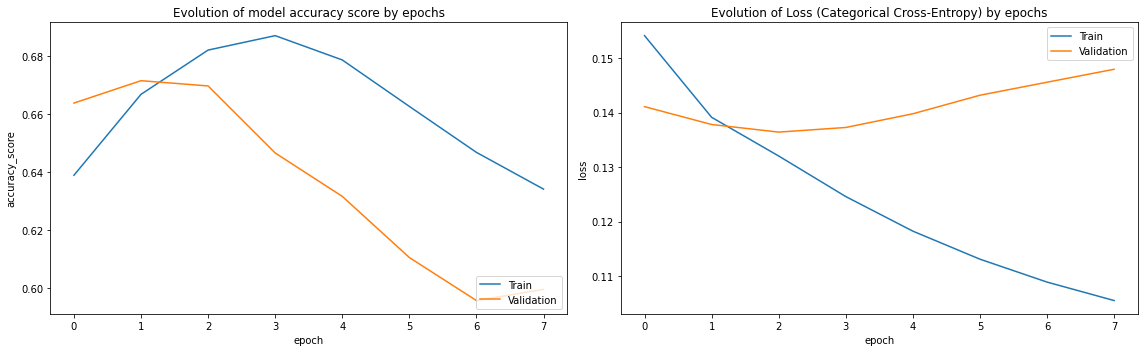

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [52]:
# Prediction and Classification report based on DNN model ...
y_val_pred = model.predict(X_val_tensor_sp_reord)
y_val_pred_bin = np.where(y_val_pred > 0.50, 1, 0)

print('Classification report based on Deep Learning:')
print(classification_report(y_val_encoded, y_val_pred_bin, target_names=np.concatenate( [np.array(['age_gt_17', 'age_gt_27', 'gender_male']), mlb.classes_] )))

Classification report based on Deep Learning:
                               precision    recall  f1-score   support

                    age_gt_17       0.85      0.92      0.89     89045
                    age_gt_27       0.67      0.33      0.44     24665
                  gender_male       0.70      0.76      0.73     69307
                sign_Aquarius       0.62      0.01      0.01      9742
                   sign_Aries       0.77      0.04      0.07     13041
                  sign_Cancer       0.88      0.06      0.12     13233
               sign_Capricorn       0.00      0.00      0.00      9841
                  sign_Gemini       0.00      0.00      0.00     10456
                     sign_Leo       1.00      0.00      0.00     10714
                   sign_Libra       0.63      0.00      0.00     12264
                  sign_Pisces       1.00      0.01      0.02     10818
             sign_Sagittarius       0.41      0.00      0.00     10079
                 sign_Scorpio 

In [53]:
# Prepare for Label Prediction ... 

# probability: age<17, age[18,27], age>27, male, sign_*, topic_*
# Note this order must match with the order as in ...
# ... np.concatenate( [np.array(['age_gt_17', 'age_gt_27', 'female', 'male']), mlb.classes_] )

y_val_pred_prob = np.c_[1-y_val_pred[:,0]                   #P[Youngest] = P[age<=17] = 1 - P[age>17]
                        , y_val_pred[:,0] - y_val_pred[:,1] #P[Adult] = P[17<age<=27] = P[age>17] - P[age>27]
                        , y_val_pred[:,1]                   #P[Elderly] = P[age>27]
                        , y_val_pred[:,2]                   #P[male]
                        , y_val_pred[:,3:]]                 #Rest of the class probabilities

In [54]:
# Prepare actual target labels
ageGrp = np.where(y_val['age_gt_27']==1, 'Elderly', np.where(y_val['age_gt_17']==1, 'Adult', 'Youngest'))

gender = np.where(y_val['gender_male']==1, 'Male', 'Female')

y_true_val = [list((i[0], i[1], i[2][0], i[2][1])) for i in np.c_[ageGrp, gender, y_val['sign_n_topic']]]

In [55]:
# Prepare predicted labels
ageGrp = np.argmax(y_val_pred_prob[:,:3], axis=1)
ageGrp = np.where(ageGrp == 0, 'Youngest', np.where(ageGrp == 1, 'Adult', 'Elderly'))

gender = np.where(y_val_pred_prob[:, 3] > 0.5, 'Male', 'Female')

#mlb.inverse_transform(np.where(y_val_pred_prob[:, 4:]>0.5, 1, 0))

# First 12 labels are from Sign
sign = mlb.classes_[np.argmax(y_val_pred_prob[:, 4:16], axis=1)]

# Next 40 labels are from Topic
topic = mlb.classes_[12 + np.argmax(y_val_pred_prob[:, 16:], axis=1)]

y_pred_val = np.c_[ageGrp, gender, sign, topic]

In [56]:
# Test on Validation set: actual vs predicton for 5 random samples:
import random

for i in range(0,5):
  n = random.choice(range(0, len(y_true_val)))

  print('Validation sample #:', n)
  print('True labels:', list(y_true_val[n]))
  print('Predicted labels:', list(y_pred_val[n]))
  print('\n')

Validation sample #: 92016
True labels: ['Youngest', 'Female', 'sign_Leo', 'topic_Student']
Predicted labels: ['Youngest', 'Female', 'sign_Virgo', 'topic_Student']


Validation sample #: 46819
True labels: ['Elderly', 'Male', 'sign_Aquarius', 'topic_indUnk']
Predicted labels: ['Adult', 'Male', 'sign_Aries', 'topic_indUnk']


Validation sample #: 59439
True labels: ['Adult', 'Male', 'sign_Leo', 'topic_Technology']
Predicted labels: ['Adult', 'Male', 'sign_Aries', 'topic_indUnk']


Validation sample #: 43470
True labels: ['Youngest', 'Female', 'sign_Libra', 'topic_Student']
Predicted labels: ['Youngest', 'Male', 'sign_Cancer', 'topic_Student']


Validation sample #: 79902
True labels: ['Adult', 'Female', 'sign_Sagittarius', 'topic_Banking']
Predicted labels: ['Adult', 'Female', 'sign_Taurus', 'topic_indUnk']




1. I tried couple of iterations with hyperparameter tuning with Deep Neural Network. The results (similar to the above one) don't seem to vary too much across the board, i.e., the validation loss doesn't tend to decrease over epochs.
2. Accuracy doesn't bear great significance in this setting as we have multiple labels for each example. From F1-score perspective, it is no better than the result of Logistic regression.
3. Probably the next logical step would be to try fitting the model for individual target set to see how results look like. That is, using the same neural network model (input bag of words, or word2vec) to fit a) Age (regression), b) Gender (binary classification), c) Sign (multilabel classification with sigmoid activation), d) Topic (multilabel classification with sigmoid activation).

## <center><font color='green'>*******End of Project Solution*******</font></center>